# Growth Rate Calculations for the Gene-by-Environment Library

The following code converts raw sgRNA counts in various media conditions to relative growth rates. This is performed by normalizing raw counts to relative counts and fitting a line to the log$_2$(Relative Counts) vs. Generations relationship, then accounting for media effects by scaling relative growth rates within each condition by the absolute growth rate of the nontargeting CRISPRi control strain in a plate reader experiment. The code also removes escapers, averages replicates, and outputs growth rate data for future analysis.

8/7/22 - Ryan Otto

### Import packages and libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import r2_score
import warnings
import plot_defaults
plot_defaults.change_defaults()

### Define relevant variables

In [2]:
date = '230307'
input_path = 'input_files'
output_path = 'intermediate_files'
figure_path = 'Figures'
BC_list = ['CATGAT', 'CCATGC', 'TGAAAG']
# The following lists deconvolute the media used in turbidostat vials
thymidine_dose_int = [0, 0.05, 1, 2, 5, 10, 50]
thymidine_dose_str = ['00.00T', '00.05T', '01.00T', '02.00T', '05.00T', '10.00T', '50.00T']
methionine_dose_int = [0, 0.01, 0.02, 0.05, 0.1, 0.3, 1.0]
methionine_dose_str = ['0.000M', '0.010M', '0.020M', '0.050M', '0.100M', '0.300M', '1.000M']
vial_conditions = ['00.00T0.00M', '50.00T0.00M', '10.00T0.00M', '05.00T0.00M', '02.00T0.00M', '01.00T0.00M',
                    '00.05T0.00M', '00.00T1.00M', '00.00T0.30M', '00.00T0.10M', '00.00T0.05M', '00.00T0.02M',
                    '00.00T0.01M', '05.00T0.01M', '02.00T0.10M', '02.00T0.01M', '01.00T0.10M', '01.00T0.05M',
                    '01.00T0.01M', '00.05T0.10M', '00.05T0.05M', '00.05T0.01M']

### Import data

In [3]:
with open(f'{input_path}/env_raw_GR_A.pickle', 'rb') as handle:
    env_raw_GR_A = pickle.load(handle)
with open(f'{input_path}/env_raw_GR_B.pickle', 'rb') as handle:
    env_raw_GR_B = pickle.load(handle)
with open(f'{input_path}/q30_filter/qscore30_counts_EnvA.pickle', 'rb') as handle:
    pairwise_dict_A = pickle.load(handle)
with open(f'{input_path}/q30_filter/qscore30_counts_EnvB.pickle', 'rb') as handle:
    pairwise_dict_B = pickle.load(handle)
for vial in ['t01', 't02', 't03', 't04', 't08']:  # Unused vials
    pairwise_dict_B.pop(vial)
for vial in pairwise_dict_B:  # Rename timepoints for convenience
    for TP, new_TP in {'T00':'T0', 'T02':'T2', 'T04':'T4', 'T06':'T6', 'T08':'T8', 'T10':'T10'}.items():
        pairwise_dict_B[vial][new_TP] = pairwise_dict_B[vial].pop(TP)
pairwise_dict = {}
for vial, counts in pairwise_dict_A.items():
    pairwise_dict[f'{vial}-A'] = counts
for vial, counts in pairwise_dict_B.items():
    pairwise_dict[f'{vial}-B'] = counts
sgRNA_list = list(pairwise_dict['t1-A']['T0']['CATGAT'].keys())
with open(f'{output_path}/230307_repression_mean_subset.pickle', 'rb') as handle:
    repression_mean_subset = pickle.load(handle)

### Define analysis functions

In [4]:
def growth_rate(sgRNA1, sgRNA2, BC_ID, dict_log, count_dict):
    """Calculates growth rate for a given barcoded sgRNA construct
    Arguments:
    sgRNA1: Name of position 1 sgRNA
    sgRNA2: Name of position 2 sgRNA
    BC_ID: Barcode identity
    dict_log: Dictionary containing log2-transformed relative frequencies
    count_dict: Dictionary contining CRISPRi construct counts at each timepoint
    TPs_hours: Timepoints (hours)
    TPs_gens: Timepoints (generations)
    Returns:
    m: Growth rate (slope) of CRISPRi construct
    """
    TPs = np.array([int(x[1:]) for x in count_dict])
    temp_vals = np.array([dict_log[TP][BC_ID][sgRNA1][sgRNA2] for TP in dict_log])
    temp_vals_counts = np.array([count_dict[TP][BC_ID][sgRNA1][sgRNA2] for TP in count_dict])
    for i, count in enumerate(temp_vals_counts):
        if count < 10:  # Filter so it won't fit any points after a point that is < 10
            temp_vals = temp_vals[:i+1]
            temp_vals_counts = temp_vals_counts[:i+1]
            TPs = TPs[:i+1]
            break
    mask = ~np.isnan(temp_vals)  # Mask removes nan values
    if len(TPs[mask]) >= 3:  # Don't fit less than three points
        m, _, _, _, _ = stats.linregress(TPs[mask], temp_vals[mask])
    else:
        m = np.nan
    return m


def qtest_dixon(replicates):
    """One-sided Dixon Q test at 95% confidence: Statistical test used for identyfing outliers in data set
    https://www.philadelphia.edu.jo/academics/ajaber/uploads/0501522-Chapter%203-Statiscal%20tests.pdf
    Used here to identify CRISPRi escapers: replicates with abnormally fast growth rates
    Argument:
    replicates: List of growth rate replicates to test for an outlier
    Returns:
    rep_sorted[:-1] or replicates: If an escaper was found, removes it. Otherwise, returns all replicates
    rep_sorted[-1] or np.nan: If an escaper was found, returns the escaper. Otherwise, returns nan.
    """
    Q30 = [0, 0, 0.941, 0.765, 0.642, 0.560]  # One-sided values, 95% confidence
    if len(replicates) >= 4:
        rep_sorted = sorted(replicates)
        gap = abs(rep_sorted[-2] - rep_sorted[-1])
        rep_range = rep_sorted[-1] - rep_sorted[0]
        if rep_range != 0:  # If all values are equal, can't run this test
            Q_val = gap / rep_range
            if Q_val >= Q30[len(replicates)-1]:
                return rep_sorted[:-1], rep_sorted[-1]
    return replicates, np.nan


def nanrms(x, axis=None):
    """Self-defined root mean square function. Used for convenience and consistency.
    Arguments:
    x: Array of residuals
    axis: In case of an array of arrays, enter the desired axis to calculate across
    Directly returns the RMSD of the residuals provided
    """
    return np.sqrt(np.nanmean(x**2, axis=axis))


def plot_correlation(x_list, y_list, x_label, y_label, min_value, max_value, file_name=None, path=None):
    """Function for making standard correlation plots
    Arguments:
    x_list: x-axis data coordinates
    y_list: y-axis data coordinates
    x_label: x-axis label
    y_label: y-axis label
    min_value: Minimum value on graph
    max_value: Maximum value on graph
    file_name: Name of saved file
    path: Path for figure output
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(x_list, y_list, color='xkcd:dark gray', alpha=0.1)
    ax.plot([min_value, max_value], [min_value, max_value], ls='--', color='xkcd:gray', lw=1, zorder=0)
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    x_list, y_list = np.array(x_list), np.array(y_list)
    mask1 = ~np.isnan(x_list) & ~np.isnan(y_list)  # Mask for shared values
    x_masked, y_masked = x_list[mask1], y_list[mask1]
    ax.text(max_value-0.5, min_value+0.1, f'R$^2$ = {np.round(r2_score(x_masked, y_masked), 2)}', fontsize=16)
    plt.tight_layout()
    if file_name:
        plt.savefig(f'{path}/{file_name}.pdf')
    plt.show()
    return

### Calculate relative sgRNA frequency and growth rates

We first normalize raw counts by the nontargeting construct at each timepoint. Then we normalize relative frequencies at every timepoint by the relative frequency at $T_0$. For all constructs with counts present through the first three timepoints, we fit a line to $log_2$(relative frequency) vs. time data. The slope of this line is the construct's relative growth rate effect.

$relative frequency_{a,T}$ = $\frac{counts_{a,T} / counts_{Nont,T}}{counts_{a,T_0} / counts_{Nont,T_0}}$

In [5]:
norm_dict = {}
for vial in pairwise_dict:
    norm_dict[vial] = {}
    for TP in pairwise_dict[vial]:
        norm_dict[vial][TP] = {}
        for BC in BC_list:
            norm_dict[vial][TP][BC] = pd.DataFrame(np.zeros([len(sgRNA_list), len(sgRNA_list)]), sgRNA_list,
                                                   sgRNA_list)
            for sgRNA1 in sgRNA_list:
                for sgRNA2 in sgRNA_list:
                    norm_dict[vial][TP][BC].loc[sgRNA1, sgRNA2] = pairwise_dict[vial][TP][BC].loc[sgRNA1, sgRNA2] \
                                                  / pairwise_dict[vial][TP][BC].loc['negC_rand_42', 'negC_rand_42']
norm_norm_dict = {}
for vial in pairwise_dict:
    norm_norm_dict[vial] = {}
    for TP in norm_dict[vial]:
        norm_norm_dict[vial][TP] = {}
        for BC in BC_list:
            norm_norm_dict[vial][TP][BC] = pd.DataFrame(np.zeros([len(sgRNA_list), len(sgRNA_list)]), sgRNA_list,
                                                        sgRNA_list)
            for sgRNA1 in sgRNA_list:
                for sgRNA2 in sgRNA_list:
                    norm_norm_dict[vial][TP][BC].loc[sgRNA1, sgRNA2] = norm_dict[vial][TP][BC].loc[sgRNA1, sgRNA2] \
                                                                     / norm_dict[vial]['T0'][BC].loc[sgRNA1, sgRNA2]
df_normed = {}
for vial in pairwise_dict:
    df_normed[vial] = {}
    for TP in norm_norm_dict[vial]:
        df_normed[vial][TP] = {}
        for BC in BC_list:
            df_normed[vial][TP][BC] = pd.DataFrame(np.zeros([len(sgRNA_list), len(sgRNA_list)]), sgRNA_list,
                                                   sgRNA_list)
            for sgRNA1 in sgRNA_list:
                for sgRNA2 in sgRNA_list:
                    temp_norm_norm = norm_norm_dict[vial][TP][BC].loc[sgRNA1, sgRNA2]
                    if temp_norm_norm != 0:
                        df_normed[vial][TP][BC].loc[sgRNA1, sgRNA2] = np.log2(temp_norm_norm)
                    else:
                        df_normed[vial][TP][BC].loc[sgRNA1, sgRNA2] = np.nan

### Restructure data and rescale growth rates by environment

Relative growth rates are rescaled by the absolute growth rate of the nontargeting CRISPRi control in the relevant media condition using the following formula. Consider CRISPRi perturbation a and media condition m.

Rescaled GR$_{a,m}$ = $\frac{Relative GR_{a,m} + Absolute GR_{Nont,m}}{Absolute GR_{Nont,M9}}$

In [6]:
scaled_growth_df = pd.DataFrame(columns = ['Indices', 'folA KD', 'thyA KD', 'thymidine []', 'methionine []', 'gr1',
                                           'gr2', 'gr3', 'gr4', 'gr5', 'gr6', 'Mean GR', 'GR SEM', 'GR STD'])
for vial in pairwise_dict:
    for i, sgRNA1 in enumerate(sgRNA_list):
        for sgRNA2 in sgRNA_list[i:]:
            gene1, gene2 = sgRNA1[0:4], sgRNA2[0:4]
            if gene1 != gene2 or gene1 == 'negC' == gene2:  # Only doing crosses of unique targets except negC x negC
                # Identify the perturbations used and each perturbation's index in our lists
                thymidine_dose = float(vial_conditions[list(pairwise_dict.keys()).index(vial)][0:5])
                thymidine_idx = str(thymidine_dose_int.index(\
                                                float(vial_conditions[list(pairwise_dict.keys()).index(vial)][0:5])))
                methionine_dose = float(vial_conditions[list(pairwise_dict.keys()).index(vial)][6:10])
                methionine_idx = str(methionine_dose_int.index(\
                                                float(vial_conditions[list(pairwise_dict.keys()).index(vial)][6:10])))
                if gene1 == 'folA':
                    folA_dose = repression_mean_subset[gene1][sgRNA1]
                else:
                    folA_dose = 0
                folA_idx = str(list(repression_mean_subset['folA'].values()).index(folA_dose))
                if gene2 == 'thyA':
                    thyA_dose = repression_mean_subset[gene2][sgRNA2]
                else:
                    thyA_dose = 0
                thyA_idx = str(list(repression_mean_subset['thyA'].values()).index(thyA_dose))
                # Concatenate all perturbation indices
                Index_holder = f'{thymidine_idx}_{methionine_idx}_{folA_idx}_{thyA_idx}'
                media_used = thymidine_dose_str[int(thymidine_idx)] + methionine_dose_str[int(methionine_idx)]
                gr_reps = []
                for BC in BC_list:
                    gr_reps.append(growth_rate(sgRNA1, sgRNA2, BC, df_normed[vial], pairwise_dict[vial]))
                    if sgRNA1 != sgRNA2:  # Nontargeting-Nontargeting is only measured 3 times
                        gr_reps.append(growth_rate(sgRNA2, sgRNA1, BC, df_normed[vial], pairwise_dict[vial]))
                    else:
                        gr_reps.append(np.nan)
                # Rescale the growth rate by the absolute growth rates in media and M9
                if media_used in env_raw_GR_B:  # Determine which plate reader experiment used this media condition
                    s_gr = env_raw_GR_B[media_used]
                    m9_gr = env_raw_GR_B['00.00T0.000M']
                else:
                    s_gr = env_raw_GR_A[media_used]
                    m9_gr = env_raw_GR_A['00.00T0.000M']
                gr_reps = [(x+s_gr) / m9_gr for x in gr_reps]
                scaled_growth_df.loc[len(scaled_growth_df.index)] = [Index_holder, folA_dose, thyA_dose,
                                        thymidine_dose, methionine_dose, gr_reps[0], gr_reps[1], gr_reps[2],
                                        gr_reps[3], gr_reps[4], gr_reps[5], np.nan, np.nan, np.nan]
# Calculate mean and sem of growth rate replicates
for i in scaled_growth_df.index:
    full_gr = list(scaled_growth_df.loc[i, 'gr1':'gr6'].values)
    if sum(~np.isnan(full_gr)) > 1:
        scaled_growth_df.loc[i, 'Mean GR':'GR STD'] = [np.nanmean(full_gr), stats.sem(full_gr, nan_policy='omit'),
                                                       np.std(full_gr)]
    elif sum(~np.isnan(full_gr)) == 1:
        scaled_growth_df.loc[i, 'Mean GR':'GR STD'] = [np.nanmean(full_gr), np.nan, np.nan]

### Compare growth rate replicates

Comparing rescaled growth rates between barcoded replicates and sgRNA orders, as done previously.

In [7]:
BC1_list = np.concatenate((scaled_growth_df['gr1'].values, scaled_growth_df['gr2'].values))
BC2_list = np.concatenate((scaled_growth_df['gr3'].values, scaled_growth_df['gr4'].values))
BC3_list = np.concatenate((scaled_growth_df['gr5'].values, scaled_growth_df['gr6'].values))
with warnings.catch_warnings():  # If we have no growth rates for a condition, returning nan is fine
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    order1_list = [np.nanmean([x1, x2, x3]) for x1, x2, x3 in zip(scaled_growth_df['gr1'].values,
                                                scaled_growth_df['gr2'].values, scaled_growth_df['gr3'].values)]
    order2_list = [np.nanmean([x1, x2, x3]) for x1, x2, x3 in zip(scaled_growth_df['gr4'].values,
                                                scaled_growth_df['gr5'].values, scaled_growth_df['gr6'].values)]
min_BC = np.nanmin([np.concatenate((BC1_list, BC2_list, BC3_list))]) - 0.1
max_BC = np.nanmax([np.concatenate((BC1_list, BC2_list, BC3_list))]) + 0.1

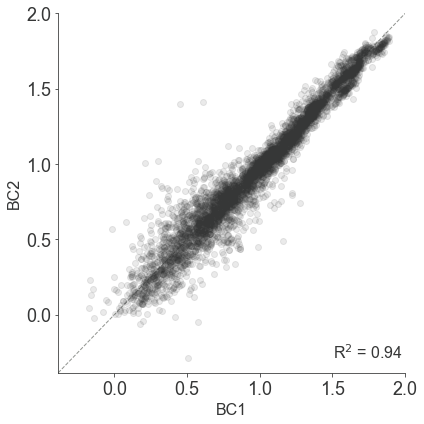

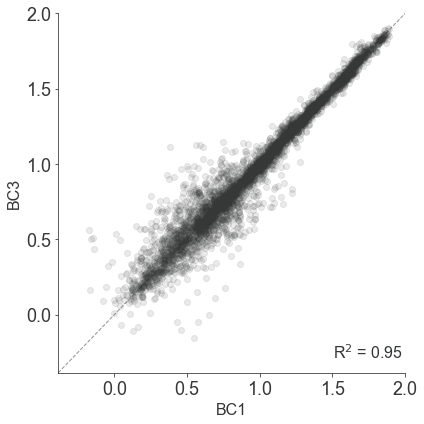

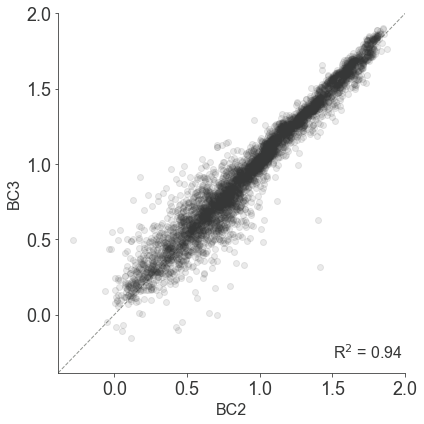

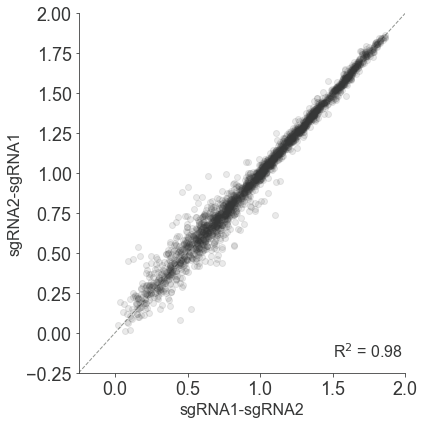

In [8]:
plot_correlation(BC1_list, BC2_list, 'BC1', 'BC2', min_BC, max_BC)
plot_correlation(BC1_list, BC3_list, 'BC1', 'BC3', min_BC, max_BC)
plot_correlation(BC2_list, BC3_list, 'BC2', 'BC3', min_BC, max_BC)
plot_correlation(order1_list, order2_list, 'sgRNA1-sgRNA2', 'sgRNA2-sgRNA1', -0.25, 2)

### Escaper correction and growth rate averaging

Remove escapers and average growth rate replicates, as described previously. For all CRISPRi perturbations except the nontargeting control, at least 4 replicates must remain following escaper filtering for an average to be taken.

In [9]:
scaled_growth_filt_df = pd.DataFrame(columns=['Indices', 'folA KD', 'thyA KD', 'thymidine []', 'methionine []',
                                                'Mean GR', 'GR SEM', 'GR STD'])
scaled_reps_filt_df = pd.DataFrame(columns=['Indices', 'gr1', 'gr2', 'gr3', 'gr4', 'gr5', 'gr6'])
escaper_dict = {}
escaper_dict2 = {}
for index, row in scaled_growth_df.iterrows():
    values = scaled_growth_df.loc[index, 'gr1':'gr6'].values
    filt_values, escaper_val = qtest_dixon(values[~np.isnan(list(values))])  # Mask nans before filtering
    if ~np.isnan(escaper_val):
        escaper_dict[scaled_growth_df.loc[index, 'Indices']] = escaper_val
        escaper_dict2[scaled_growth_df.loc[index, 'Indices']] = np.where(values == escaper_val)[0][0]
    if scaled_growth_df.loc[index, 'Indices'].endswith('0_0'):  # Nontargeting-Nontargeting has only 3 replicates
        req_vals = 3
    else:
        req_vals = 4
    if len(filt_values) >= req_vals:
        temp_reps = [scaled_growth_df.loc[index, 'Indices']]
        temp_reps += list(filt_values)
        while len(temp_reps) < 7:
            temp_reps.append(np.nan)
        scaled_reps_filt_df.loc[len(scaled_reps_filt_df)] = temp_reps
        scaled_growth_filt_df.loc[len(scaled_growth_filt_df)] = \
                    [scaled_growth_df.loc[index, 'Indices'], scaled_growth_df.loc[index, 'folA KD'],
                     scaled_growth_df.loc[index, 'thyA KD'], scaled_growth_df.loc[index, 'thymidine []'],
                     scaled_growth_df.loc[index, 'methionine []'], np.nanmean(filt_values), stats.sem(filt_values),
                     np.std(filt_values)]
    else:
        scaled_reps_filt_df.loc[len(scaled_reps_filt_df)] = [scaled_growth_df.loc[index, 'Indices'], np.nan, np.nan,
                                                               np.nan, np.nan, np.nan, np.nan]
        scaled_growth_filt_df.loc[len(scaled_growth_filt_df)] = \
                    [scaled_growth_df.loc[index, 'Indices'], scaled_growth_df.loc[index, 'folA KD'],
                     scaled_growth_df.loc[index, 'thyA KD'], scaled_growth_df.loc[index, 'thymidine []'],
                     scaled_growth_df.loc[index, 'methionine []'], np.nan, np.nan, np.nan]
print(f'Total escapers: {len(escaper_dict)}')
print(f"\
{np.round(len(escaper_dict)/sum(~np.isnan(scaled_growth_df.loc[:, 'gr1':'gr6'].values.flatten()))*100, 2)}% of data")
# Rearrange into a 4D array for exporting
growth_rates_mean = np.full((len(thymidine_dose_int), len(methionine_dose_int), len(repression_mean_subset['folA']),
                              len(repression_mean_subset['thyA'])), np.nan)
growth_rates_std = np.full((len(thymidine_dose_int), len(methionine_dose_int), len(repression_mean_subset['folA']),
                              len(repression_mean_subset['thyA'])), np.nan)
growth_rates_reps = np.full((len(thymidine_dose_int), len(methionine_dose_int), len(repression_mean_subset['folA']),
                              len(repression_mean_subset['thyA']), 6), np.nan)
for index, row in scaled_growth_filt_df.iterrows():
    idx = [int(i) for i in scaled_growth_filt_df.loc[index, 'Indices'].split('_')]
    growth_rates_mean[idx[0], idx[1], idx[2], idx[3]] = scaled_growth_filt_df.loc[index, 'Mean GR']
    growth_rates_std[idx[0], idx[1], idx[2], idx[3]] = scaled_growth_filt_df.loc[index, 'GR STD']
    for rep in range(6):
        growth_rates_reps[idx[0], idx[1], idx[2], idx[3], rep] = scaled_reps_filt_df.loc[index, f'gr{rep+1}']

Total escapers: 125
0.87% of data


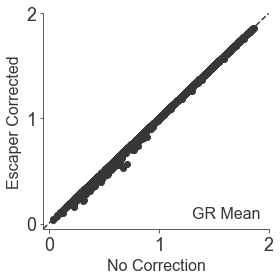

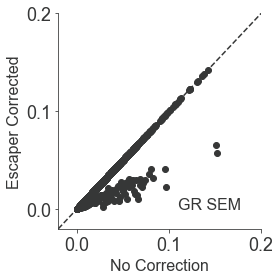

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(scaled_growth_df['Mean GR'].values, scaled_growth_filt_df['Mean GR'].values, marker='o',
           color='xkcd:dark gray')
ax.plot([-0.05, 2], [-0.05, 2], ls='--', color='xkcd:dark gray', zorder=0)
ax.text(1.3, 0.05, 'GR Mean', fontsize=16)
ax.set_xlim(-0.05, 2)
ax.set_ylim(-0.05, 2)
ax.set_xticks([0, 1, 2])
ax.set_yticks([0, 1, 2])
ax.set_xlabel('No Correction', fontsize=16)
ax.set_ylabel('Escaper Corrected', fontsize=16)
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(scaled_growth_df['GR SEM'].values, scaled_growth_filt_df['GR SEM'].values, marker='o',
           color='xkcd:dark gray')
ax.plot([-0.02, 0.2], [-0.02, 0.2], ls='--', color='xkcd:dark gray', zorder=0)
ax.set_xlim(-0.02, 0.2)
ax.set_ylim(-0.02, 0.2)
ax.set_xticks([0, 0.1, 0.2])
ax.set_yticks([0, 0.1, 0.2])
ax.set_xlabel('No Correction', fontsize=16)
ax.set_ylabel('Escaper Corrected', fontsize=16)
ax.text(0.11, 0, 'GR SEM', fontsize=16)
plt.tight_layout()
plt.show()

### Visualize growth rate data

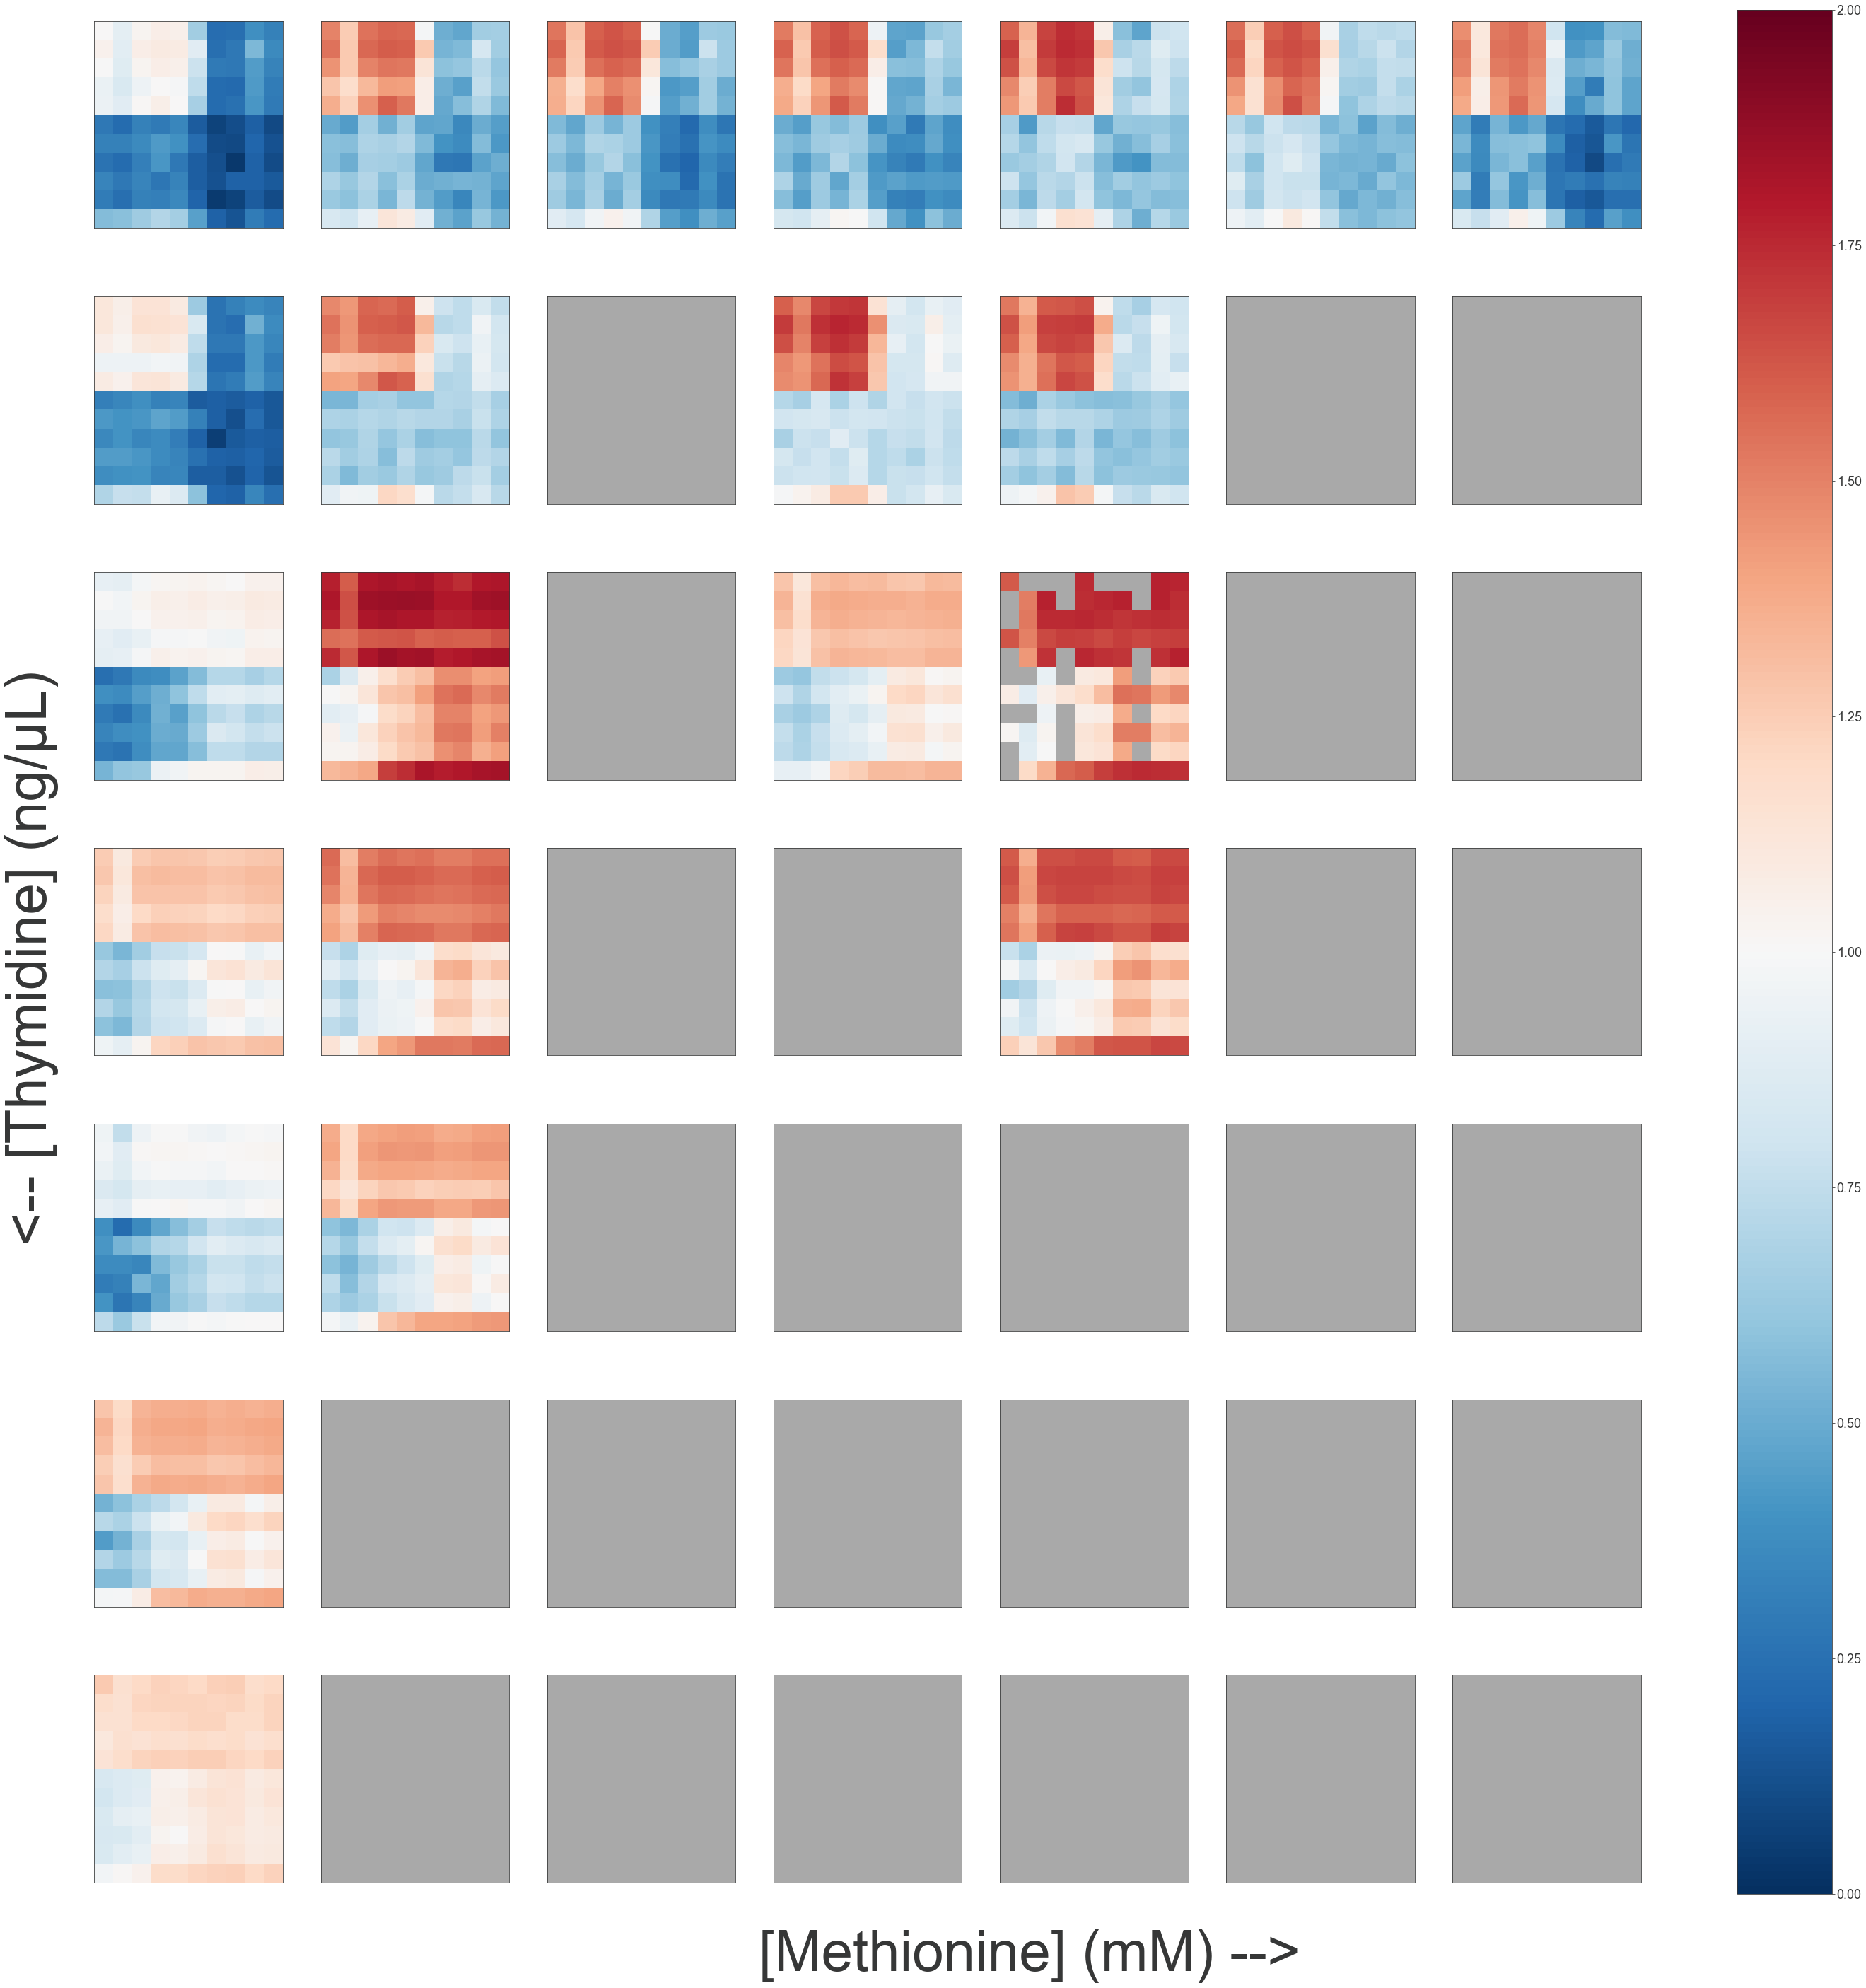

In [11]:
fig, ax = plt.subplots(7, 7, figsize=(49, 49))
for i in range(7):
    for j in range(7):
        cb = ax[i, j].imshow(growth_rates_mean[i, j, :, :], cmap="RdBu_r", vmin=0, vmax=2)
        ax[i, j].set_facecolor("darkgrey")
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].spines[['top', 'right']].set_visible(True)
fig.text(0.5, 0.1, '[Methionine] (mM) -->', ha='center', va='center', fontsize=80)
fig.text(0.1, 0.5, '<-- [Thymidine] (ng/μL)', ha='center', va='center', rotation='vertical', fontsize=80)
plt.colorbar(cb, ax=ax.ravel().tolist())
plt.savefig(f'{figure_path}/Fig6B.pdf', transparent=False)
plt.show()

### Export data

In [12]:
with open(f'{output_path}/{date}_growth_rates_mean.pickle', 'wb') as handle:
    pickle.dump(growth_rates_mean, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{output_path}/{date}_growth_rates_std.pickle', 'wb') as handle:
    pickle.dump(growth_rates_std, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{output_path}/{date}_repression_mean_subset.pickle', 'wb') as handle:
    pickle.dump(repression_mean_subset, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'{output_path}/{date}_growth_rates_reps.pickle', 'wb') as handle:
    pickle.dump(growth_rates_reps, handle, protocol=pickle.HIGHEST_PROTOCOL)
with pd.ExcelWriter(f'Supplementary_Tables.xlsx', mode='a', if_sheet_exists='replace') as writer:
    np.round(scaled_growth_filt_df, 3).to_excel(writer, sheet_name='Table Extra4')